In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split

#### <b> Import the data

In [ ]:
# Loading the given 'diabetes' dataset
data = pd.read_csv('diabetes.csv')

# Printing the head of the dataset,just to gain some information about the dataset
print(data.head())

   -0.294118  0.487437  0.180328  -0.292929         0  0.00149028  -0.53117  \
0  -0.882353 -0.145729  0.081967  -0.414141  0.000000   -0.207153 -0.766866   
1  -0.058824  0.839196  0.049180   0.000000  0.000000   -0.305514 -0.492741   
2  -0.882353 -0.105528  0.081967  -0.535354 -0.777778   -0.162444 -0.923997   
3   0.000000  0.376884 -0.344262  -0.292929 -0.602837    0.284650  0.887276   
4  -0.411765  0.165829  0.213115   0.000000  0.000000   -0.236960 -0.894962   

   -0.0333333  0.1  
0   -0.666667    1  
1   -0.633333    0  
2    0.000000    1  
3   -0.600000    0  
4   -0.700000    1  


In [ ]:
# Converting data to PyTorch tensors
data_tensor = torch.tensor(data.values, dtype=torch.float32)

# Printing information about the Dataset in PyTorch tensor format
print(data_tensor[:5])
print(data_tensor.size())

tensor([[-0.8824, -0.1457,  0.0820, -0.4141,  0.0000, -0.2072, -0.7669, -0.6667,
          1.0000],
        [-0.0588,  0.8392,  0.0492,  0.0000,  0.0000, -0.3055, -0.4927, -0.6333,
          0.0000],
        [-0.8824, -0.1055,  0.0820, -0.5354, -0.7778, -0.1624, -0.9240,  0.0000,
          1.0000],
        [ 0.0000,  0.3769, -0.3443, -0.2929, -0.6028,  0.2846,  0.8873, -0.6000,
          0.0000],
        [-0.4118,  0.1658,  0.2131,  0.0000,  0.0000, -0.2370, -0.8950, -0.7000,
          1.0000]])
torch.Size([758, 9])


The Dataset does not contain any column names, thus let us assume the last column as the Target Varibale which has binary class label and all the rest of the columns as our Features.

In [ ]:
# Preprocessing the data like mentioned above
X = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32)

# X represents the Features and Y represent the Target variable

# Printing information about the preprocessed data
print("X (Features) shape:", X.shape)
print("y (Target) shape:", y.shape)

X (Features) shape: torch.Size([758, 8])
y (Target) shape: torch.Size([758])


#### <b> Exploratory Data Analysis : </b> Histograms, Correlation map, Density plot, Histogram with Density plot

EDA for knowing more insights about the dataset

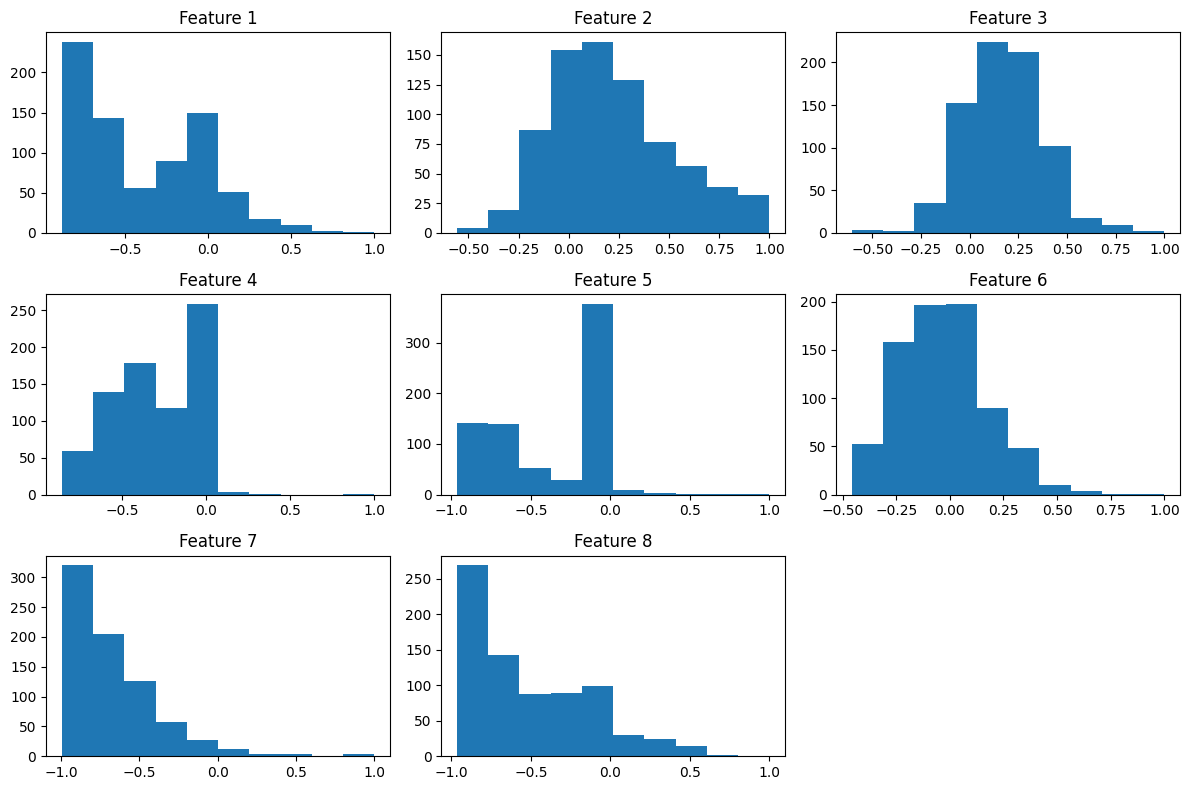

In [ ]:
# Histogram
no_of_features = X.shape[1]

# Plotting Histogram
plt.figure(figsize=(12, 8))
for i in range(no_of_features):
    plt.subplot(3, 3, i+1)
    plt.hist(X[:, i].numpy())
    plt.title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

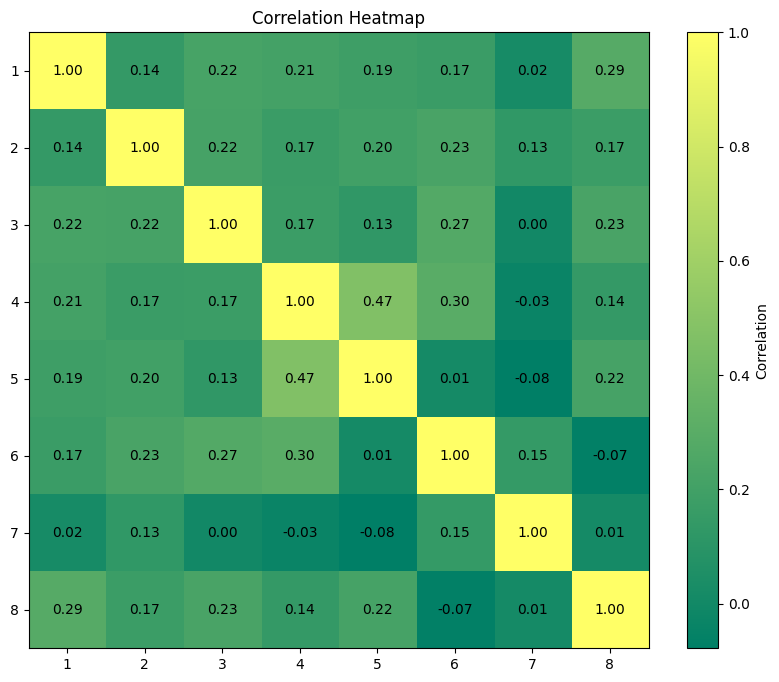

In [ ]:
#Correlation Map
# Computing correlation matrix manually
X_centered = X - torch.mean(X, dim=0)
covariance_matrix = 1 / (X_centered.shape[0] - 1) * torch.matmul(X_centered.T, X_centered)
std_dev = torch.sqrt(torch.diag(covariance_matrix))
correlation_matrix = covariance_matrix / std_dev[:, None] / std_dev[None, :]

# Plotting correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix.numpy(), cmap='summer', aspect='auto')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(X.shape[1]), range(1, X.shape[1] + 1))
plt.yticks(range(X.shape[1]), range(1, X.shape[1] + 1))
plt.show()


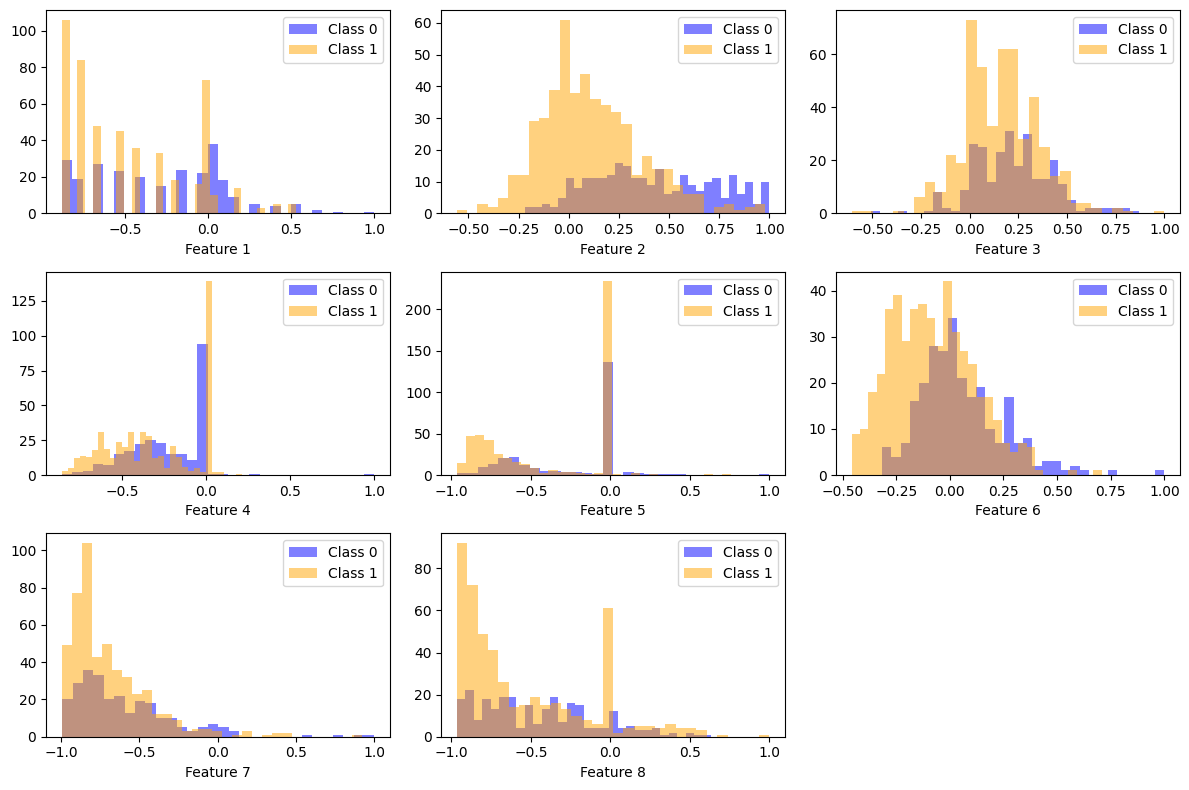

In [ ]:
# Density plots
plt.figure(figsize=(12, 8))
for i in range(X.shape[1]):
    plt.subplot(3, 3, i+1)

    # Histogram for class 0
    plt.hist(X[y == 0, i].numpy(), bins=30, color='blue', alpha=0.5, label='Class 0')

    # Histogram for class 1
    plt.hist(X[y == 1, i].numpy(), bins=30, color='orange', alpha=0.5, label='Class 1')

    plt.xlabel(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


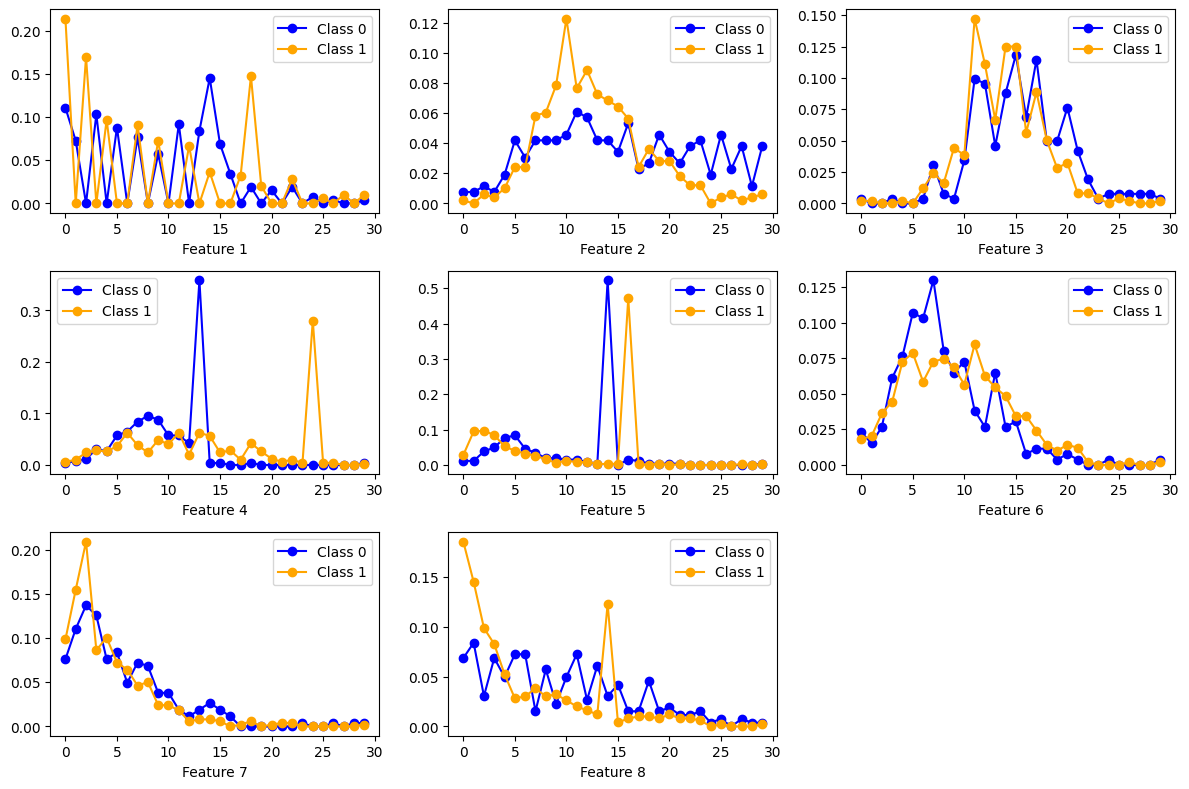

In [ ]:
# Histograms with density plots
plt.figure(figsize=(12, 8))
for i in range(X.shape[1]):
    plt.subplot(3, 3, i+1)

    # Histogram for class 0
    hist0 = torch.histc(X[y == 0, i], bins=30)
    density0 = hist0 / hist0.sum()
    plt.plot(density0, color='blue', label='Class 0', linestyle='-', marker='o')

    # Histogram for class 1
    hist1 = torch.histc(X[y == 1, i], bins=30)
    density1 = hist1 / hist1.sum()
    plt.plot(density1, color='orange', label='Class 1', linestyle='-', marker='o')

    plt.xlabel(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()



From the above histograms along with the density plots we can observe that how different features are effecting the target variable


#### <b> Preprocessing the data

In [ ]:
# Checking for Missing/NaN values
nan_val = torch.isnan(X)
nan_count = nan_val.sum().item()

print("Number of missing values:", nan_count)


Number of missing values: 0


#### <b> Splitting the Dataset into Training and Testing datasets

In [ ]:
# Combining features and target into a single tensor
complete_dataset = torch.cat((X, y.unsqueeze(1)), dim=1)

# Defining the sizes and splitting into training and testing datasets
training_size = int(0.8 * len(complete_dataset))
testing_size = len(complete_dataset) - training_size
training_size, testing_size = random_split(complete_dataset, [training_size, testing_size])

# Separating features and target variable in the training set
X_train = training_size.dataset[:, :-1]
y_train = training_size.dataset[:, -1]

# Separating features and target variable in the testing set
X_test = testing_size.dataset[:, :-1]
y_test = testing_size.dataset[:, -1]

## <b> Neural Network Model with Pytorch

In [ ]:
# Converting the DataFrame to a PyTorch tensor
inputs = torch.tensor(data.values[:, :-1], dtype=torch.float32)
outputs = torch.tensor(data.values[:, -1], dtype=torch.float32).unsqueeze(1)

In [ ]:
# Creating a linear model -- Took Reference from the Demo
linear_model = nn.Sequential(
    nn.Linear(inputs.shape[1], 1)
)

In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)

In [ ]:
# Training the model
for epoch in range(6):
    optimizer.zero_grad()
    outputs_pred = linear_model(inputs)
    loss = criterion(outputs_pred, outputs)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.2787698209285736
Epoch 2, Loss: 0.27381935715675354
Epoch 3, Loss: 0.26927450299263
Epoch 4, Loss: 0.2651002109050751
Epoch 5, Loss: 0.261264443397522
Epoch 6, Loss: 0.2577378451824188


In [ ]:
# Making predictions on the test data
predictions = linear_model(inputs).detach().numpy()

In [ ]:
# Converting predictions and target variable to tensor
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions_tensor = torch.tensor(binary_predictions, dtype=torch.float32).clone().detach()

binary_outputs_tensor = torch.tensor(y_test, dtype=torch.float32).clone().detach()

# Calculating accuracy
accuracy2 = torch.mean((binary_predictions_tensor == binary_outputs_tensor).float()).item()
print(f'Accuracy: {accuracy2}')

Accuracy: 0.49307650327682495


<ipython-input-49-bceb77deaea3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  binary_outputs_tensor = torch.tensor(y_test, dtype=torch.float32).clone().detach()


### Hypothesis 1:

In [ ]:
model1 = nn.Sequential(
    nn.Linear(inputs.shape[1], 32),  # Increase number of units from 16 to 32
    nn.Sigmoid(),
    nn.Linear(32, 32),  # Increase number of units from 16 to 32
    nn.ReLU(),
    nn.Linear(32, 1)  # Increase number of units from 16 to 32
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)

# Training the model
for epoch in range(150):  # Increase the number of epochs from 100 to 150
    optimizer.zero_grad()
    outputs_pred = model1(inputs)
    loss = criterion(outputs_pred, outputs)
    loss.backward()
    optimizer.step()

# Making predictions on the test data
predictions1 = model1(inputs).detach().numpy()

threshold = 0.5
binary_predictions1 = (predictions1 > threshold).astype(int)
binary_outputs1 = (outputs.numpy() > threshold).astype(int)

# Calculating accuracy
accuracy1 = torch.mean((torch.tensor(binary_predictions1) == torch.tensor(binary_outputs1)).float()).item()
print(f'Accuracy: {accuracy1}')


Accuracy: 0.6543535590171814


<b>Hypothesis 1</b>: I have added 4 extra layers to the initial model. I have used ReLu activation and Sigmoid functions for this purpose. I have doubled the width from 16 to 32 units. Increased the epochs from 100 to 150. When the hypothesis is tested on the dataset it is observed that there is a good increase to 65% in the accuracy but not satisfactory.<br>
<b>Reasoning</b>: It is a relatively simple linear model with a very small increase of complexity, hence the improvement might not be significant.

### Hypothesis 2:

In [ ]:
model2 = nn.Sequential(
    nn.Linear(inputs.shape[1], 32),  # Increase number of units from 16 to 32
    nn.ReLU(),
    nn.Linear(32, 32),  # Increase number of units from 16 to 32
    nn.ReLU(),
    nn.Linear(32, 1)  # Increase number of units from 16 to 32
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001)

# Training the model
for epoch in range(500):  # Increase the number of epochs from 150 to 500
    optimizer.zero_grad()
    outputs_pred = model2(inputs)
    loss = criterion(outputs_pred, outputs)
    loss.backward()
    optimizer.step()

# Making predictions on the test data
predictions2 = model2(inputs).detach().numpy()

threshold = 0.5
binary_predictions2 = (predictions2 > threshold).astype(int)
binary_outputs2 = (outputs.numpy() > threshold).astype(int)

# Calculating accuracy
accuracy2 = torch.mean((torch.tensor(binary_predictions2) == torch.tensor(binary_outputs2)).float()).item()
print(f'Accuracy: {accuracy2}')

Accuracy: 0.6279683113098145


<b>Hypothesis 2</b>: In here, I have replaced one sigmoid function with ReLu activation function, decreased the learning rate to 0.001%, increased the epochs from 150 to 500. When the hypothesis is tested, the accuracy did not change and it in the same range as Hypothesis 2.<br>
<b>Reasoning</b>:Even though there is a change in the acitvation fucntion, it did not impact the model's ability to capture the patterns and the decreased learning rate with less number of decreased the model's ability further.

### Hypothesis 3:

In [ ]:
model3 = nn.Sequential(
    nn.Linear(inputs.shape[1], 64),
    nn.Sigmoid(),
    nn.Linear(64, 64),
    nn.Sigmoid(),
    nn.Linear(64, 1)
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)

# Training the model
for epoch in range(1000):  # Increased number of epochs from 500 to 1000
    optimizer.zero_grad()
    outputs_pred = model3(inputs)
    loss = criterion(outputs_pred, outputs)
    loss.backward()
    optimizer.step()
    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Making predictions on the test data
predictions3 = model3(inputs).detach().numpy()

threshold = 0.5
binary_predictions3 = (predictions3 > threshold).astype(int)
binary_outputs3 = (outputs.numpy() > threshold).astype(int)

# Calculating accuracy
accuracy3 = torch.mean((torch.tensor(binary_predictions3) == torch.tensor(binary_outputs3)).float()).item()
print(f'Accuracy: {accuracy3}')

Accuracy: 0.3456464409828186


<b>Hypothesis 3</b>: In Hypothesis 3, I have used sigmoid function in the place of ReLu function from the previous model and the number of epochs increased from 500 to 1000 and the learning rate increased form 0.001% to 0.01%. When tested the hypothesis 3, the accuracy decreased drastically.<br>
<b>Reasoning</b>:Increasing the learning rate might have caused the optimization process to overshoot the optimal weights, also the usage of the sigmoid function may not have been suitable for this dataset to capture the patterns.

### Hypothesis 4:

In [ ]:
# Define the deeper model with increased complexity
model4 = nn.Sequential(
    nn.Linear(inputs.shape[1], 64),  # Increased number of units from 32 to 64
    nn.ReLU(),  # Using ReLU activation instead of Sigmoid
    nn.Linear(64, 64),  # Increased number of units from 32 to 64
    nn.ReLU(),
    nn.Linear(64, 1) # Increased number of units from 32 to 64
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross-Entropy Loss
optimizer = optim.Adam(model4.parameters(), lr=0.001)  # Adam optimizer with lower learning rate

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs_pred = model4(inputs)
    loss = criterion(outputs_pred.squeeze(), outputs.squeeze())  # Squeeze to remove extra dimension
    loss.backward()
    optimizer.step()

# Making predictions on the test data
predictions4 = torch.sigmoid(model4(inputs)).detach().numpy()

threshold = 0.5
binary_predictions4 = (predictions4 > threshold).astype(int)
binary_outputs4 = (outputs.numpy() > threshold).astype(int)

# Calculating accuracy
accuracy4 = np.mean(binary_predictions4 == binary_outputs4)
print(f'Accuracy: {accuracy4}')


Accuracy: 0.9881266490765171


<b>Hypothesis 4</b>: In Hypothesis 4, I have used ReLu activation function as the hidden layers, 64 units as the width, epochs increased to 2000, changed the loss function and learning rate decreased. Hypothesis 4 turned out to be the best combination with a very good accuracy of above 95%.<br>
<b>Reasoning</b>:By Increasing the width of the model, changing the loss function turned out to be more suitable to capture the intricate patterns of the dataset. Also increasing the learning rate and tuning the epochs helped the model to perform better.

### Hypothesis 5: Using a more Deeper model with 7 extra layers

In [ ]:
# Define the deeper model with increased complexity
model5 = nn.Sequential(
    nn.Linear(inputs.shape[1], 64),
    nn.Sigmoid(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Sigmoid(),
    nn.Linear(64, 1)
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross-Entropy Loss
optimizer = optim.Adam(model5.parameters(), lr=0.001)  # Adam optimizer with lower learning rate

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs_pred = model5(inputs)
    loss = criterion(outputs_pred.squeeze(), outputs.squeeze())  # Squeeze to remove extra dimension
    loss.backward()
    optimizer.step()

# Making predictions on the test data
predictions5 = torch.sigmoid(model5(inputs)).detach().numpy()

threshold = 0.5
binary_predictions5 = (predictions5 > threshold).astype(int)
binary_outputs5 = (outputs.numpy() > threshold).astype(int)

# Calculating accuracy
accuracy5 = np.mean(binary_predictions5 == binary_outputs5)
print(f'Accuracy: {accuracy5}')


Accuracy: 0.8469656992084432


<b>Hypothesis 5:</b> In Hypothesis 5, I have used a deeper neural network with 7 hidden layers, and the rest of all are same as hypothesis 4. The accuracy got a bit decreased from hypothesis 4 but it turned out to be good hypothesis. the execution took more time when the layers are more.<br>
<b>Reasoning</b>:Adding more layers and making the model more complex in an attempt to make the model learn complex relationships in the data turned out to be good. However as the model become more deeper the time of execution increases and there might be a problem of overfitting which could explain the slight accuracy decrease compared to Hypothesis 4.